# Causal Inference Experiments

The purpose of this notebook is to implement the ideas that I had learned throughout the Short Course in Causal Inference taught by Lok, Hernán, Robins, VanderWeele, and Tchetgen-Tchetgen. This will focus on models that estimate the average causal effect (ACE) that have general applicability (i.e. unbiased in time-fixed _and_ time-varying scenarios, assuming certain assumptions are met). Matching, outcome regression, etc., are known to produce biased estimates of ACE in the latter scenario. Instead, we'll be looking at g-formula, mean structural models, structural nested mean models, which have broader applicability. 

Later, we'll also discuss mediation, instrumental variables, and the do-calculus.

## Import statements

In [180]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

%matplotlib inline

## Time-Fixed Treatments

### Average Treatment Effect Over Whole Population

Our treatment is X and our outcome is Y. If we were to increase X, how would Y change? Let's say we're interested in seeing the effect of X on Y by increasing X from 0 to 1. One formalization of that is the causal risk difference where X changes from 0 to 1. Using Pearl's $do$-notation, that is $E(Y \mid do(X=1)) - E(Y \mid do(X=0))$. Equivalently, in Potential Outcomes notation, it is $E(Y^{X=1}) - E(Y^{X=0})$. We'll be estimating this quantity in different scenarios.

#### Binary Treatments

Let's take the scenario where a confounder masks the effect of treatment. Let's say that the drug does work to improve recovery of people. For example, on average, taking the treatment ($X=1$) improves recovery ($Y=1$), but people with a severe disease ($Z=1$) are more likely to take the drug in the population. For the sake of simplicity, let's assume there's no other confounder.

The causal diagram is as follows:

![X points to Y. Z points to both X and Y. X points to Y.](img/time-fixed-simple-causal-dag.png) 

Naively looking at $P(Y=1 \mid X=1) - P(Y=0 \mid X=1)$ might make it seem that taking the drug on average makes it worse for people to take the drug. However, we know _a priori_ that it's not the case. We'll show the the drug, on average, is actually good for people in our population. But first, let's generate some data.

In [303]:
SMALL_SAMPLE_SIZE = 100
BIGGER_SAMPLE_SIZE = 1000
HUGE_SAMPLE_SIZE=1000000

In [304]:
def generate_x(z):
    if z == 1: # people with a severe disease
        # likely to take the drug
        return np.random.binomial(n=1,p=0.8)
    else:
        return np.random.binomial(n=1,p=0.4)

In [305]:
def generate_y(x,z):
    if x==0 and z==0: # if take no treatment while not sick
        return np.random.binomial(n=1,p=0.9)
    elif x==1 and z==1: # if take treatment while sick
        return np.random.binomial(n=1,p=0.1)
    elif x==0 and z==1: # if don't take treatment while sick
        return np.random.binomial(n=1,p=0.05)
    else: # if take treatment while not sick
        return np.random.binomial(n=1,p=0.9)

In [306]:
def generate_confounded_data(sample_size):
    z = np.random.binomial(n=1, p=0.9, size=sample_size)
    x = pd.Series(z).apply(generate_x)
    y = [generate_y(_x,_z) for _x, _z in zip(x,z)]
    
    return pd.DataFrame({
        'z': z,
        'x': x,
        'y': y
    })

In [309]:
huge_drug_confounded_df = generate_confounded_data(HUGE_SAMPLE_SIZE)

Now, let's compute $P(Y=1 \mid X=1) - P(Y=0 \mid X=1)$, also known as the Associative Risk Difference.

In [321]:
print(
    'The Associative Risk Difference is', 
    np.round(
        huge_drug_confounded_df[huge_drug_confounded_df['x'] == 1]['y'].mean() \
             - huge_drug_confounded_df[huge_drug_confounded_df['x'] == 0]['y'].mean(),
        2
    )
)

The Associative Risk Difference is -0.12


As seen above, the associative risk difference $P(Y=1 \mid X=1) - P(Y=1 \mid X=0)$ is negative! The people who take the drug are worse off than the people who don't take the drug. However, we know this is not the causal estimate of the drug in our population. Those who take the treatment tend to recover less because they were already sick to begin with:

![More people with severe cases take the drug than don't](img/time-fixed-incomparable.jpg)

In other words, those who were treated and those who weren't treated are not comparable. Severity is a common cause of the treatment and outcome that could explain some of the association between the treatment and outcome. In graphical terms, an open backdoor path between $X$ and $Y$ exists through $X \leftarrow Z \rightarrow Y$ that is transmitting spurious association between $X$ and $Y$.

To find the true effect in our population, we can use the data generating process with a huge sample size to generate 2 sets of data: 1. where we force everyone to take the drug, and 2. where we force everyone not to take the drug.

We can then subtract the two and then take the mean to find the causal risk difference:

In [322]:
z = np.random.binomial(n=1, p=0.9, size=HUGE_SAMPLE_SIZE)
print(
    'The Causal Risk Difference is',
    np.round(
        (np.array([
            generate_y(_x,_z) for _x, _z in zip(np.ones(HUGE_SAMPLE_SIZE),z)
        ]) - np.array([
            generate_y(_x,_z) for _x, _z in zip(np.zeros(HUGE_SAMPLE_SIZE),z)
        ])).mean(),
        2
    )
)

The Causal Risk Difference is 0.04


We can see now that on average, taking treatment increases recovery by about 4-5 percentage points compared to not taking treatment! This is an unconfounded estimate. This is in contrast to the average associative risk difference of -12 percentage points, which was confounded. Naively looking at the probability of recovery on the treated and untreated would lead to biased estimates when there is confounding, especially in cases where treatment is not randomized, like in observational studies. However, assuming we have access to the right data, we can make adjustments to identify the true effect.

#### G-Formula

If we have no unmeasured confounding, and infinite sample size, we could identify the causal effect of some treatment on an outcome, without having to run a randomized control trial. One way to do so is the G-Formula, which was originally discovered by Robins in 1986 [TODO: insert link here].

The G-Formula, which Pearl describes as the Adjustment Formula, for time-fixed treatments is:

$$
\begin{equation}
\begin{aligned}
    P[Y=1 \mid do(X=x)] &= \sum_z P[Y=1 \mid X=x, Z=z] \cdot P(Z=z)
\end{aligned}
\end{equation}
$$

### Derivation A

One way to derive this result, as shown by Pearl in [Causal Inference in Statistics: A Primer](http://bayes.cs.ucla.edu/PRIMER/) is to make use of the factorization of the joint distribution:

$$
\begin{equation}
\begin{aligned}
    P(x_1, ..., x_n) &= \prod_{i \subset V} P(x_i \mid x_{\text{parents(i)}})
\end{aligned}
\end{equation}
$$

The joint distribution for the causal graph of our current problem is then:

$$
\begin{equation}
\begin{aligned}
    P(x, y, z) &= P(y \mid x, z) \cdot P(x \mid z) \cdot P(z)
\end{aligned}
\end{equation}
$$

What if treatment was no longer confounded by severity $Z$? For example, let's just say that the drug was randomly assigned to people without regard to their severity status:

![Remove arrow from Z to X](img/time-fixed-modified-graph.png)

In the modified graph, $X$ no longer listens to $Z$. That would correspond to a modification on the graph where we remove the arrow from $Z$ to $X$. The joint distribution now becomes:

$$
\begin{equation}
\begin{aligned}
    P_m(X=1, y, z) &= P_m(y \mid X=1, z) \cdot P_m(X=1) \cdot P_m(z)
\end{aligned}
\end{equation}
$$

Note that the association between $X$ and $Y$ in the modified graph (i.e. $P_m(Y=1 \mid X=1)$) has a causal interpretation. To get this quantity, we could look at the subset of people where $X=1$, and sum out values for $z$:

$$
\begin{equation}
\begin{aligned}
    P_m(y, z \mid X=1) &= \frac{ P_m(y \mid X=1, z) \cdot P_m(X=1) \cdot P_m(z) }{ P_m(X=1) }\\
    &= P_m(y \mid X=1, z) \cdot P_m(z) \\
    \sum_z P_m(y, Z=z \mid X=1) &= \sum_z P_m(y \mid X=1, z) \cdot P_m(z) \\
    &= \sum_z P(y \mid X=1, Z=z) \cdot P(Z=z) & \text{invariance across the two graphs} \\
    &= P_m(y \mid X=1)
\end{aligned}
\end{equation}
$$

We have derived the g-formula for time-fixed treatments! It can be interpreted as the association between treatment $X$ and outcome $Y$ in a world where treatment is no longer confounded by other variables, everything else being the same.

### Derivation B

Another way to derive the G-Formula is through the Single World Intervention Graph (SWIG), which explicitly shows the relationship between the causal diagram and the counterfactuals:

![](img/time-fixed-swig)

When an intervention is done, $X$ gets split into two nodes. The left is the observed $X$, which depends on $Z$. The right one is the intervention $X=1$. Since this is an intervention, the node $X=1$ (in blue) doesn't have any arrows leading to it. Intervening on the population to give them the same treatment $X=1$ then gives us the counterfactual outcome $Y^{X=1}$. From the SWIG, we can see a path from $X$ to $Y^{X=1}$: $X \leftarrow Z \rightarrow Y^{X=1}$. By $d$-separation, we know that conditioning on $Z$ blocks the flow of information between $X$ and $Y^{X=1}$. Thus, we know that $Y^{X=1} \mathrel{\unicode{x2AEB}} X \mid Z$. This is called conditional exchangeability. In other words, having conditioned on $Z$, the observed treatment group $X$ is independent of what we're trying to estimate, $Y^{X=1}$. The treated ($X=1$) and the untreated ($X=0$) are exchangeable / comparable after conditioning on confounder $Z$, as severity $Z$ would then be evenly distributed between the two treatment groups. Because of this even distribution of severity of disease in the two groups, the average treatment effect on either groups should be the same. We'll exploit this in another derivation of the G-Formula:

$$
\begin{equation}
\begin{aligned}
    P(Y^{X=1}=1) &= \sum_z P(Y^{X=1}=1, Z=z) \\
    &= \sum_z P(Y^{X=1}=1 \mid Z=z) \cdot P(Z=z) \\
    &= \sum_z P(Y^{X=1}=1 \mid X=1, Z=z) \cdot P(Z=z) & \text{Since }Y^{X=1} \mathrel{\unicode{x2AEB}} X \mid Z \\
    &= \sum_z P(Y=1 \mid X=1, Z=z) \cdot P(Z=z) & \text{consistency} \\
\end{aligned}
\end{equation}
$$

The last step uses consistency. In this case, it says that the observed probability of recovery for those who got treated in subpopulation $Z=z$ is the same as the counterfactual outcome $Y^{X=1}=1$ in the subpopulation $Z=z$.

Consistency says that the observed outcome for every treated individual equals her outcome if she had received treatment, and that the observed outcome for every untreated individual equals her outcome if she had remained untreated (i.e. $Y^x = Y \mid X$). Given that we have exchangeability / comparability after having conditioned on $Z$, consistency could then remove the counterfactual from the right-hand side, which means we could identify the causal effect of $X$ on $Y$ given observational data!

### Causal Risk Difference via the G-Formula

Applying the G-Formula to both $X=1$ and $X=0$ and then subtracting the two gives us the causal risk difference:

$$
\begin{equation}
\begin{aligned}
    P[Y=1 \mid do(X=1)] - P[Y=1 \mid do(X=0)] &= \sum_z P[Y=1 \mid X=1, Z=z] \cdot P(Z=z) - \sum_z P[Y=1 \mid X=0, Z=z] \cdot P(Z=z) \\
    &= \sum_z \big( P[Y=1 \mid X=1, Z=z] - P[Y=1 \mid X=0, Z=z] \big) \cdot P(Z=z) \\
\end{aligned}
\end{equation}
$$

Note that our strategy for calculating the causal risk difference above, where we force everyone to take the drug vs. force everyone not to take the drug, and then taking the average, is the same as applying the G-Formula! We're basically looking at a weighted average of the observed quantities $P[Y=1 \mid X=1, Z=z] - P[Y=1 \mid X=0, Z=z]$, that is, the difference in recovery $Y$ for people who did take the treatment ($X=1$), taking into account their severity ($Z=z$) vs. those who did not take the treatment ($X=0$), also taking into account severity $Z=z$. We weight those differences by the prevalence of the different values of $Z$ in the population (i.e. $P(Z=z)$) and arrive at a causal result through the sum of those weighted differences. We've been applying the G-Formula all along!

However, we usually don't have access to the true data generating process, and we usually have a finite / small sample size. Let's see if we can recover the true effect by estimation. Let's generate some sample data first.

In [320]:
small_sample_drug_confounded_df = generate_confounded_data(SMALL_SAMPLE_SIZE)

#### Simple Normal Models

Let's say we know the true data-generating process so we can check results of different models later:

$$
\begin{equation}
\begin{aligned}
    Z_i &\sim Normal(\mu=-1, \sigma=1) \\
    X_i &\sim Normal(\mu=Z_i + 3, \sigma=1) \\
    Y_i &\sim Normal(\mu=-3X_i + 2Z_i, \sigma=2) \\
\end{aligned}
\end{equation}
$$

Since this is a simple example, we can see that the average effect of changing $X$ on $Y$ is $-3$, therefore $E(Y \mid do(X=1)) - E(Y \mid do(X=0)) = -3$. Now, let's generate some samples and get an intuition of how well Bayesian and frequentist implementations of the g-methods estimate the true causal effect.

First, let's generate a smaller sample from the data-generating process. We will use this data to estimate the true difference.

In [183]:
z = np.random.normal(loc=-1, scale=1, size=SMALL_SAMPLE_SIZE) 
x = np.random.normal(loc=z+3, scale=1)
y = np.random.normal(loc=-3*x + 2*z, scale=2)

In [184]:
df = pd.DataFrame({
    'x': x,
    'z': z,
    'y': y,
    'ones': 1,
    'zeros': 0
})

df

,x,z,y,ones,zeros
0,2.467009,-0.147090,-4.780203,1,0
1,2.291504,-0.947474,-10.670062,1,0
2,3.257408,-1.206429,-13.572128,1,0
3,1.792357,-0.084401,0.911804,1,0
4,1.175717,-1.041898,-6.815395,1,0
5,1.627591,-0.645818,-8.565036,1,0
6,2.200413,-1.140263,-7.486187,1,0
7,-0.557393,-2.765862,-5.421241,1,0
8,1.208233,-0.391662,-4.986591,1,0
9,0.786288,-0.215116,-3.490922,1,0


First, let's do Bayesian estimation. In Bayesian analyses, we can make educated guesses about what the parameters are by the use of priors.

$$
\begin{equation}
\begin{aligned}
    Y_i &\sim Normal(\mu=\beta_X \cdot X_i + \beta_Z \cdot Z_i, \sigma=\sigma_Y) \\
    \sigma_Y &\sim HalfNormal(\sigma=3) \\
    \beta_Z &\sim Normal(\mu=0, \sigma=3) \\
    \beta_X &\sim Normal(\mu=0, \sigma=3) \\
    X_i &\sim Normal(\mu=Z_i + \alpha_X, \sigma=\sigma_X) \\
    \sigma_X &\sim HalfNormal(\sigma=3) \\
    \alpha_X &\sim Normal(\mu=0, \sigma=3) \\
    Z_i &\sim Normal(\mu=\mu_Z, \sigma=1) \\
    \mu_Z &\sim Normal(\mu=0, \sigma=3) \\
\end{aligned}
\end{equation}
$$

In [185]:
with pm.Model() as time_fixed_model:
    z_mu = pm.Normal('z_mu', mu=0, sd=3) # weakly-informative prior
    z_var = pm.Normal('z', mu=z_mu, sd=1, observed=z)
    
    alpha_x = pm.Normal('alpha_x', 0, 3)
    x_var_sd = pm.HalfNormal('x_sd', sd=3)
    x_var = pm.Normal('x', mu=z_var + alpha_x, sd=x_var_sd, observed=x)
    
    y_var_sd = pm.HalfNormal('y_sd', sd=3)
    
    beta_X = pm.Normal('beta_X', mu=0, sd=3)
    beta_Z = pm.Normal('beta_Z', mu=0, sd=3)
    
    y_mu = beta_X * x_var + beta_Z * z_var
    y_var = pm.Normal('y', mu=y_mu, sd=y_var_sd, observed=y)
    
    time_fixed_traces = pm.sample(traces=1000)

INFO (theano.gof.compilelock): Refreshing lock /Users/eddericugaddan/.theano/compiledir_Darwin-18.5.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_Z, beta_X, y_sd, x_sd, alpha_x, z_mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2058.66draws/s]


GridSpec(1, 2, width_ratios=[3, 1])

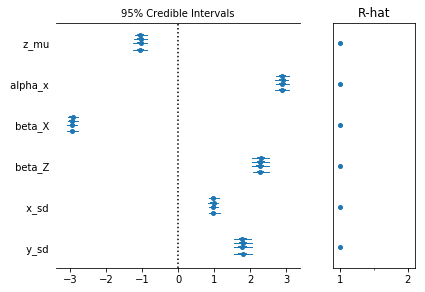

In [186]:
pm.forestplot(time_fixed_traces)

Based on the plot above, the true parameters are right in the middle of the credible intervals. Great! Now that we've computed the posterior distribution, let's use it to compute estimates.

#### G-Formula

The G-Formula for the specific problem above is:

$$
\begin{equation}
\begin{aligned}
    E[Y \mid do(X=x)] &= \sum_l E[Y \mid X=x, Z=z] \cdot P(Z=z)
\end{aligned}
\end{equation}
$$

We can estimate this quantity by creating a model for $\sum_l E[Y \mid X=x, Z=z]$ 

In [187]:
def frequentist_g_formula_sklearn(df, bootstrap_size):
    
    model = LinearRegression()

    for i in range(bootstrap_size):
        sample = df.sample(df.shape[0], replace=True)
        model.fit(sample[['x','z']], sample['y'])
        
        # compute mean causal effect
        y_do_x_eq_1 = model.predict(sample[['ones', 'z']])
        y_do_x_eq_0 = model.predict(sample[['zeros', 'z']])
        
        means.append((y_do_x_eq_1 - y_do_x_eq_0).mean())
        
    return pd.Series(means)

    

In [188]:
def frequentist_g_formula_statsmodels(df, bootstrap_size):
    
    for i in range(bootstrap_size):
        sample = df.sample(df.shape[0], replace=True)
        
        ols = sm.OLS(endog=sample['y'], exog=sample[['x', 'z']]) 
        model = ols.fit()
        
        # compute mean causal effect
        y_do_x_eq_1 = model.predict(sample[['ones', 'z']])
        y_do_x_eq_0 = model.predict(sample[['zeros', 'z']])
        
        means.append((y_do_x_eq_1 - y_do_x_eq_0).mean())
        
    return pd.Series(means)

    

In [189]:
freq_bootstrap = frequentist_g_formula_sklearn(df, bootstrap_size=len(time_fixed_traces['x_sd']))

In [190]:
freq_bootstrap.mean()

-3.2297273839038514

In [191]:
freq_bootstrap_statsmodels = frequentist_g_formula_statsmodels(df, bootstrap_size=len(time_fixed_traces['x_sd']))

In [192]:
freq_bootstrap_statsmodels.mean()

-3.1809761647711214

In [200]:
def summarize(model_name, samples, lower=2.5, upper=97.5, interval='confidence'):
    return  model_name + ': The 95% ' + interval + ' interval when applying the parametric g-formula is (' + \
        str(np.round(np.percentile(samples, lower), 2)) + ', '  + \
        str(np.round(np.percentile(samples, upper), 2)) + \
        ') with mean ' + str(np.round(samples.mean(), 2))



In [201]:
def bayesian_g_formula(traces, df):
    means = []
    for i in range(len(traces['x_sd'])):
        new_z = df.sample(100, replace=True)['z']
        y_1 = traces['beta_X'][i] * 1 + traces['beta_Z'][i] * new_z
        y_0 = traces['beta_X'][i] * 0 + traces['beta_Z'][i] * new_z
        means.append((y_1 - y_0).mean())
        
    return pd.Series(means)

In [202]:
bayesian_estimates = bayesian_g_formula(time_fixed_traces, df)

In [203]:
results = [
    {
        'model_name': 'Scikit Learn',
        'samples': freq_bootstrap,
        'interval': 'confidence',
        'samples_type': 'bootstrap'
    },
    {
        'model_name': 'Statsmodels',
        'samples': freq_bootstrap_statsmodels,
        'interval': 'confidence',
        'samples_type': 'bootstrap'
    },
    {
        'model_name': 'PyMC3',
        'samples': bayesian_estimates,
        'interval': 'credible',
        'samples_type': 'posterior predictive'
    }
]


In [204]:
for i in results:
    print(
        summarize(
            model_name=i['model_name'], 
            samples=i['samples'], 
            interval=i['interval']
        )
    )
    

Scikit Learn: The 95% confidence interval when applying the parametric g-formula is (-4.03, -2.57) with mean -3.23
Statsmodels: The 95% confidence interval when applying the parametric g-formula is (-4.01, -2.59) with mean -3.18
PyMC3: The 95% credible interval when applying the parametric g-formula is (-3.08, -2.79) with mean -2.94


As we can see from above, all of the intervals contain the mean. However, the 95% credible interval is much narrower than the 95% confidence intervals obtained above. We can get a sense of the width by actually plotting the bootstrap samples for the two frequentist models and one Bayesian model:

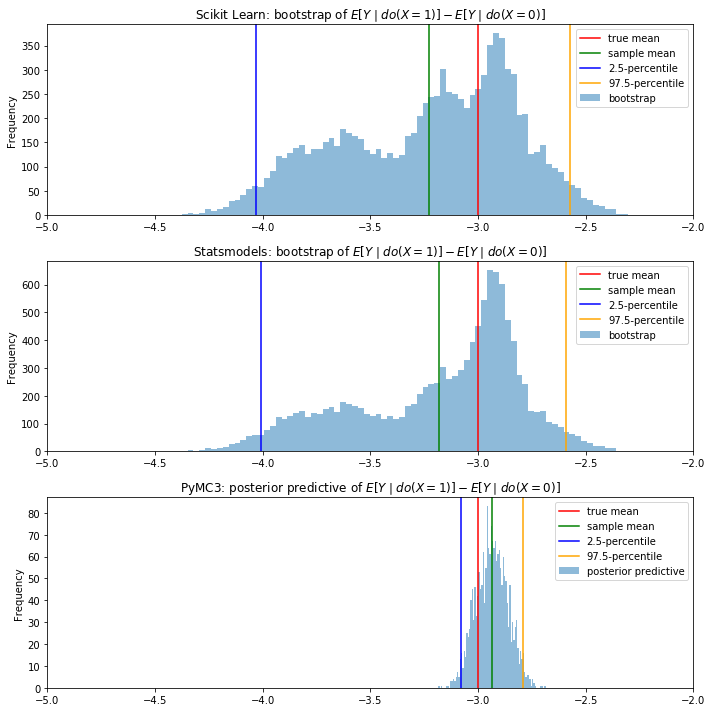

In [209]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

for i, result in enumerate(results):
    result['samples'].plot.hist(
        bins=80, 
        title=result['model_name'] + ': ' + result['samples_type'] + ' of $E[Y \mid do(X=1)] - E[Y \mid do(X=0)]$', 
        ax=ax[i], 
        label=result['samples_type'],
        alpha=0.5
    )
    ax[i].axvline(x=-3, color='r', label='true mean')
    ax[i].axvline(x=result['samples'].mean(), color='green', label='sample mean')
    ax[i].axvline(x=np.percentile(result['samples'], 2.5), color='blue', label='2.5-percentile')
    ax[i].axvline(x=np.percentile(result['samples'], 97.5), color='orange', label='97.5-percentile')
    ax[i].legend(loc='upper right')
    ax[i].set_xlim(-5,-2)
plt.tight_layout()

Because we're using weakly informative priors centered at 0, the Bayesian posterior distribution gets pulled closer to 0 than the frequentist counterparts.

In [44]:
pd.Series(z).sample(100, replace=True)

87   -0.573666
58   -1.083162
96   -1.728001
45   -1.222511
97   -1.674680
16   -1.684333
73    1.287633
2    -3.416970
25   -0.264515
43   -1.030983
0    -0.011785
55   -1.472651
29   -1.037536
75    0.326178
64   -2.023368
18   -0.090132
69   -0.052656
76   -1.022882
35   -0.679064
91   -0.535724
1     0.048204
8    -1.427146
5    -3.841123
6    -1.377343
93   -2.351034
24    1.623685
95   -0.390571
29   -1.037536
35   -0.679064
38   -1.395103
        ...   
69   -0.052656
82   -0.317409
3    -2.587894
85    0.704214
60   -0.549648
55   -1.472651
53   -1.049760
7    -0.675275
23   -2.087719
91   -0.535724
36    0.551060
98   -1.471506
47   -2.420601
2    -3.416970
79    0.100614
63   -0.824045
40    0.456737
20   -0.218207
59   -1.161846
56   -1.742730
34   -0.897639
56   -1.742730
39   -0.485043
61    0.862746
91   -0.535724
10   -0.769939
65   -0.835173
45   -1.222511
89   -0.428932
42   -2.122136
Length: 100, dtype: float64

In [36]:
np.array([[1], [2], [3]]) * np.array([1,2,3])

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [37]:
posterior_values_per_z = z.reshape((100,1)) * time_fixed_traces['z_mu'].reshape((1, time_fixed_traces['z_mu'].shape[0]))

In [ ]:
np.ones(100)

In [41]:
np.random.normal(loc=1 ,scale=time_fixed_traces['y_sd'])

array([-1.00883783,  2.40225169,  0.03586726, ...,  0.87572017,
        2.2164828 , -0.28871437])

In [26]:
z * time_fixed_traces['z_mu']

ValueError: operands could not be broadcast together with shapes (100,) (2000,) 

#### Inverse Probability Treatment Weighting & Marginal Structural Models 

#### Structural Nested Mean Models & G-Estimation

### Average Treatment Effect Over Sub-Population

This is also known as $z$-_specific_ effect by Pearl. See Causal Inference in Statistics: A Primer, chapter 3.

## Time-Varying Treatments

### No Unobserved Confounders

### Unobserved Confounder Satisfies Sequential Ignorability

### Unobserved Confounder Violates Sequential Ignorability

### G-Formula

### Inverse Probability Treatment Weighting & Marginal Structural Models 

### Structural Nested Mean Models & G-Estimation

### Censoring